In [1]:
import tensorflow as tf
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss
import collections
from dataset import ptb

In [110]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
#         self.grads = [tf.Variable(tf.zeros_like(W))]
        self.grads = [tf.Variable(tf.zeros_like(W))]
        self.idx = None
        
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W.numpy()[idx, :]
        return tf.Variable(out)
    
    def backward(self, dout):
#         for word_id in self.idx:
#             self.grads[0].assign(self.grads[0] + tf.slice(dout, [word_id, 0], [1, dout.shape[1]]))
        grads_np = np.zeros_like(self.params[0].numpy())
        grads_np[self.idx, :] += dout.numpy()
        self.grads[0].assign(grads_np)
        return None

In [111]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
        
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = tf.math.reduce_sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = tf.reshape(dout, (dout.shape[0], 1))
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [112]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        self.counts = collections.Counter(corpus.numpy())
        vocab_size = len(self.counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = self.counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(list(self.counts.keys()), size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [113]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.samplar = UnigramSampler(corpus, power, sample_size)
        self.loss_layer = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params = []
        self.grads = []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.samplar.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = tf.ones(batch_size, dtype='int32')
        loss = self.loss_layer[0].forward(score, correct_label)

        negative_label = tf.zeros(batch_size, dtype='int32')
        for i in range(self.sample_size):
            negative_target = negative_sample[:, 1]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layer[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layer, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

In [114]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))
        W_out = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


In [115]:
from common.util import preprocess, create_contexts_target, convert_one_hot
from common.optimizer import Adam
from common.functions import softmax, cross_entropy_error

In [116]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + tf.math.exp(-x))
        self.loss = cross_entropy_error(tf.constant([1 - self.y.numpy(), self.y.numpy()]),
                                        tf.constant([1 - self.t.numpy(), self.t.numpy()], dtype='float32'))
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - tf.dtypes.cast(self.t, dtype='float32')) * dout / batch_size
        return dx

In [117]:
def cross_entropy_error(y, t):
    num_label = y.shape[0]
#     print(y.shape)
    if t.ndim == 1:
        t = tf.constant(np.identity(num_label)[t.numpy()], dtype='float')
    batch_size = y.shape[1]

    return -tf.reduce_sum(tf.math.log(y)*t) / batch_size

In [118]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
from common.np import *  # import numpy as np
from common.util import clip_grads
import tensorflow as tf

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = tf.random.shuffle(tf.range(data_size)).numpy()
            x = x[idx]
            t = t[idx]
            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                optimizer.update(model.params, model.grads)
                total_loss += loss
                loss_count += 1
                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [119]:
import time

In [136]:
start = time.time()
# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
# text = 'You say goodbye and I say hello.'
# corpus, word_to_id, id_to_word = preprocess(text)

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus = tf.constant(corpus)
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)
print(time.time() - start)

494.97179651260376


In [137]:
# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 4[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 8[s] | loss 4.13
| epoch 1 |  iter 61 / 9295 | time 12[s] | loss 3.99
| epoch 1 |  iter 81 / 9295 | time 17[s] | loss 3.89
| epoch 1 |  iter 101 / 9295 | time 21[s] | loss 3.89
| epoch 1 |  iter 121 / 9295 | time 25[s] | loss 3.82
| epoch 1 |  iter 141 / 9295 | time 29[s] | loss 3.80
| epoch 1 |  iter 161 / 9295 | time 33[s] | loss 3.78
| epoch 1 |  iter 181 / 9295 | time 38[s] | loss 3.76
| epoch 1 |  iter 201 / 9295 | time 42[s] | loss 3.76
| epoch 1 |  iter 221 / 9295 | time 46[s] | loss 3.74
| epoch 1 |  iter 241 / 9295 | time 50[s] | loss 3.67
| epoch 1 |  iter 261 / 9295 | time 54[s] | loss 3.72
| epoch 1 |  iter 281 / 9295 | time 59[s] | loss 3.72
| epoch 1 |  iter 301 / 9295 | time 63[s] | loss 3.64
| epoch 1 |  iter 321 / 9295 | time 67[s] | loss 3.70
| epoch 1 |  iter 341 / 9295 | time 71[s] | loss 3.67
| epoch 1 |  iter 361 / 9295 | time 7

| epoch 1 |  iter 2961 / 9295 | time 622[s] | loss 3.51
| epoch 1 |  iter 2981 / 9295 | time 626[s] | loss 3.50
| epoch 1 |  iter 3001 / 9295 | time 630[s] | loss 3.47
| epoch 1 |  iter 3021 / 9295 | time 634[s] | loss 3.49
| epoch 1 |  iter 3041 / 9295 | time 639[s] | loss 3.54
| epoch 1 |  iter 3061 / 9295 | time 643[s] | loss 3.53
| epoch 1 |  iter 3081 / 9295 | time 647[s] | loss 3.51
| epoch 1 |  iter 3101 / 9295 | time 651[s] | loss 3.52
| epoch 1 |  iter 3121 / 9295 | time 655[s] | loss 3.47
| epoch 1 |  iter 3141 / 9295 | time 659[s] | loss 3.51
| epoch 1 |  iter 3161 / 9295 | time 664[s] | loss 3.49
| epoch 1 |  iter 3181 / 9295 | time 668[s] | loss 3.47
| epoch 1 |  iter 3201 / 9295 | time 672[s] | loss 3.46
| epoch 1 |  iter 3221 / 9295 | time 676[s] | loss 3.49
| epoch 1 |  iter 3241 / 9295 | time 680[s] | loss 3.48
| epoch 1 |  iter 3261 / 9295 | time 685[s] | loss 3.41
| epoch 1 |  iter 3281 / 9295 | time 689[s] | loss 3.50
| epoch 1 |  iter 3301 / 9295 | time 693[s] | lo

| epoch 1 |  iter 5881 / 9295 | time 1231[s] | loss 3.43
| epoch 1 |  iter 5901 / 9295 | time 1236[s] | loss 3.44
| epoch 1 |  iter 5921 / 9295 | time 1240[s] | loss 3.46
| epoch 1 |  iter 5941 / 9295 | time 1244[s] | loss 3.40
| epoch 1 |  iter 5961 / 9295 | time 1248[s] | loss 3.34
| epoch 1 |  iter 5981 / 9295 | time 1252[s] | loss 3.36
| epoch 1 |  iter 6001 / 9295 | time 1257[s] | loss 3.42
| epoch 1 |  iter 6021 / 9295 | time 1261[s] | loss 3.39
| epoch 1 |  iter 6041 / 9295 | time 1265[s] | loss 3.41
| epoch 1 |  iter 6061 / 9295 | time 1269[s] | loss 3.44
| epoch 1 |  iter 6081 / 9295 | time 1273[s] | loss 3.44
| epoch 1 |  iter 6101 / 9295 | time 1278[s] | loss 3.43
| epoch 1 |  iter 6121 / 9295 | time 1282[s] | loss 3.44
| epoch 1 |  iter 6141 / 9295 | time 1286[s] | loss 3.44
| epoch 1 |  iter 6161 / 9295 | time 1290[s] | loss 3.41
| epoch 1 |  iter 6181 / 9295 | time 1294[s] | loss 3.38
| epoch 1 |  iter 6201 / 9295 | time 1299[s] | loss 3.40
| epoch 1 |  iter 6221 / 9295 |

KeyboardInterrupt: 

In [138]:
word_vecs.numpy()[word_to_id['and']]

array([-0.09515672,  0.19175366, -0.00521946,  0.12827146,  0.08398496,
       -0.00368624, -0.06837357, -0.3067216 ,  0.0280181 ,  0.05105996,
        0.11365145,  0.27883512, -0.01074899,  0.10626857, -0.12060522,
        0.02509419,  0.1287024 ,  0.12075949, -0.1669756 ,  0.11371189,
        0.09995188, -0.08504936, -0.24357823, -0.312678  , -0.2535549 ,
        0.04039108,  0.21945576,  0.13762042, -0.25966632,  0.15046394,
        0.06152108,  0.22142877, -0.13093215,  0.08544157,  0.22669505,
        0.19041117,  0.00549628,  0.20289133,  0.06710194,  0.28464207,
        0.14027312,  0.07994741, -0.12984921,  0.07886861, -0.09659693,
       -0.01715551, -0.11354088, -0.1681149 ,  0.10218746,  0.12850848,
       -0.09125027,  0.04881507,  0.36869717, -0.27636907,  0.13506028,
       -0.09355669, -0.06014849,  0.09114479, -0.02712603, -0.0341729 ,
        0.02463563, -0.0210257 , -0.06536174, -0.12065198, -0.08622468,
       -0.05491001, -0.1105256 , -0.08281759,  0.12351169,  0.22

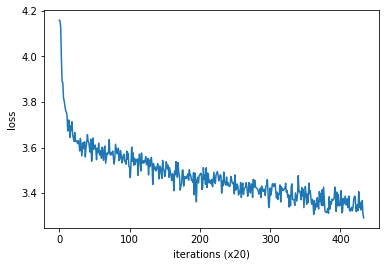

In [139]:
import pickle
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [140]:
from common.util import most_similar

In [141]:
querys = ['you','year','cat','toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 stepping: 0.9746652245521545
 content: 0.9620257616043091
 secure: 0.9616966247558594
 equaling: 0.9602655172348022
 spoken: 0.9585345983505249

[query] year
 mo.: 0.9569869637489319
 rather: 0.9472987651824951
 thousand: 0.9407504200935364
 more: 0.9383667707443237
 less: 0.915993332862854

[query] cat
 comfortable: 0.9853246808052063
 nobody: 0.9665930867195129
 reforms: 0.9578949213027954
 jose: 0.9570389986038208
 relief: 0.9565960168838501

[query] toyota
 laws: 0.9738577008247375
 decision: 0.9673885703086853
 stocks: 0.9613497853279114
 pc: 0.9601082801818848
 spawned: 0.9574313759803772
